In [2]:
# align.py
import numpy as np
def read_align(path_to_align = None):
    with open(path_to_align, 'r') as f:
        lines = f.readlines()	
    align = [(int(y[0])/1000, int(y[1])/1000, y[2]) for y in [x.strip().split(" ") for x in lines]]
    words = []
    words.append('sil')
    for i in range(75):
    	for j in align:
	    	if i > j[0] and i <= j[1]:
	    		words.append(j[2])
    dict_align  = np.array(words)
    return dict_align

In [3]:
# video.py
import dlib
from skvideo.io import vread
from scipy.misc import imresize
def read_video(path, face_predictor_path, verbose=False):
    if verbose:
        print("loading: " + path)
    video = vread(path)
    frames = np.array([frame for frame in video])
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(face_predictor_path)
    mouth_video = get_frames_mouth(detector, predictor, frames)

    return np.array(mouth_video)

def get_frames_mouth(detector, predictor, frames):
        MOUTH_WIDTH = 100
        MOUTH_HEIGHT = 50
        HORIZONTAL_PAD = 0.19
        normalize_ratio = None
        mouth_frames = []
        for frame in frames:
            dets = detector(frame, 1)
            shape = None
            for k, d in enumerate(dets):
                shape = predictor(frame, d)
                i = -1
            if shape is None: # Detector doesn't detect face, just return as is
                return frames
            mouth_points = []
            for part in shape.parts():
                i += 1
                if i < 48: # Only take mouth region
                    continue
                mouth_points.append((part.x,part.y))
            np_mouth_points = np.array(mouth_points)

            mouth_centroid = np.mean(np_mouth_points[:, -2:], axis=0)

            if normalize_ratio is None:
                mouth_left = np.min(np_mouth_points[:, :-1]) * (1.0 - HORIZONTAL_PAD)
                mouth_right = np.max(np_mouth_points[:, :-1]) * (1.0 + HORIZONTAL_PAD)

                normalize_ratio = MOUTH_WIDTH / float(mouth_right - mouth_left)

            new_img_shape = (int(frame.shape[0] * normalize_ratio), int(frame.shape[1] * normalize_ratio))
            resized_img = imresize(frame, new_img_shape)

            mouth_centroid_norm = mouth_centroid * normalize_ratio

            mouth_l = int(mouth_centroid_norm[0] - MOUTH_WIDTH / 2)
            mouth_r = int(mouth_centroid_norm[0] + MOUTH_WIDTH / 2)
            mouth_t = int(mouth_centroid_norm[1] - MOUTH_HEIGHT / 2)
            mouth_b = int(mouth_centroid_norm[1] + MOUTH_HEIGHT / 2)

            mouth_crop_image = resized_img[mouth_t:mouth_b, mouth_l:mouth_r]

            mouth_frames.append(mouth_crop_image)
        return mouth_frames

In [21]:
# data.py
import os
#from align import read_align
#from video import read_video

# different from file
CURRENT_PATH = '/home/ubuntu/Project/machine-lip-reading/preprocessing'
DATA_PATH = CURRENT_PATH + '/../data'
PREDICTOR_PATH = CURRENT_PATH + '/shape_predictor_68_face_landmarks.dat'

def load_data(verbose=False, framebyframe=False):
    for root, dirs, files in os.walk(DATA_PATH):
        for name in files:
            if '.mpg' in name:
                if verbose is True:
                    print("reading: " + root)
                video = read_video(os.path.join(root, name), PREDICTOR_PATH)
                words = read_align(os.path.join(root, '../align/', name.split(".")[0] + ".align"))
               
                if verbose is True:
                    print("video shape:", video.shape)
                    print("alignments shape:", words.shape)

                if framebyframe:
                    for frame, word in zip(video, words):
                        yield frame, word
                else:
                    yield video, words

/home/ubuntu/Project/machine-lip-reading/preprocessing/../data/s7/video/pgbd7s.mpg


/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/__main__.py:46: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


0
sil


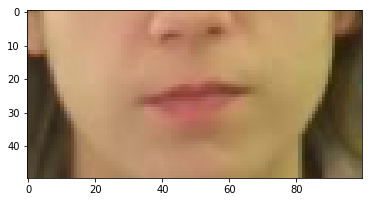

1


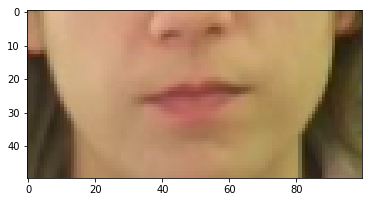

2


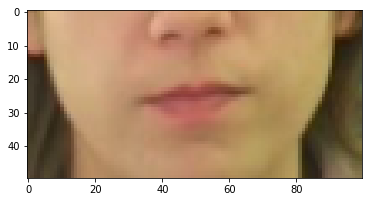

3


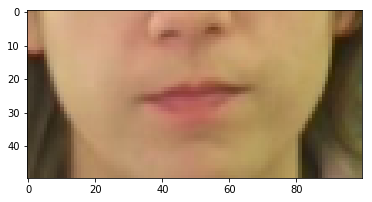

4


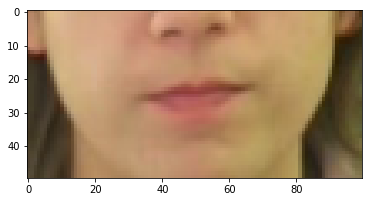

5


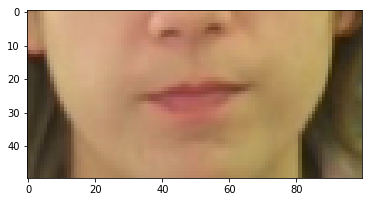

6


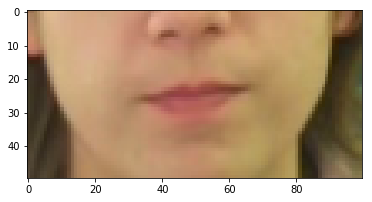

7


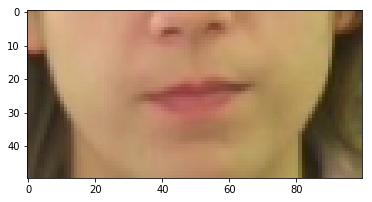

8


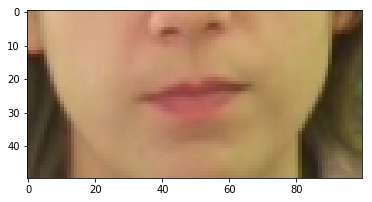

9


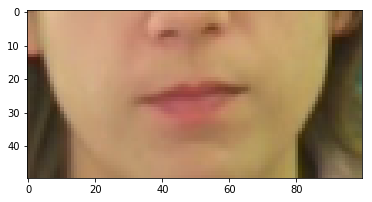

10


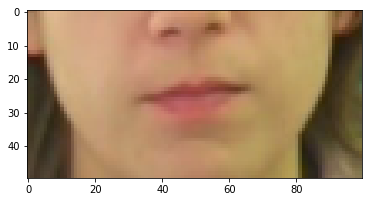

11


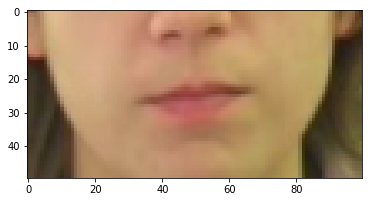

12
place


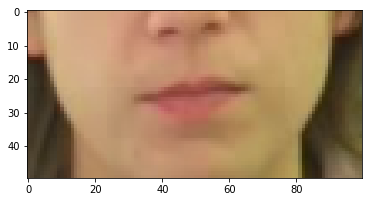

13


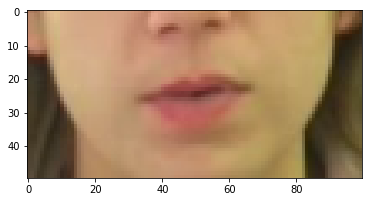

14


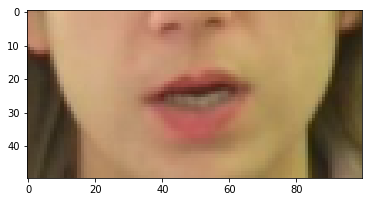

15


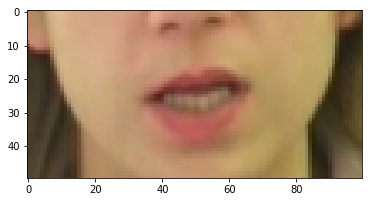

16


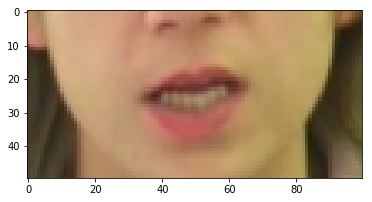

17


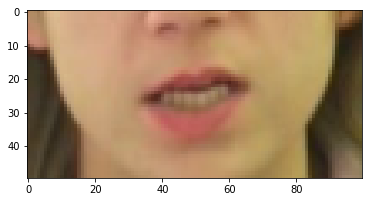

18


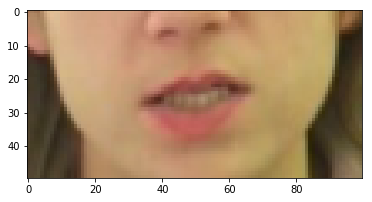

19


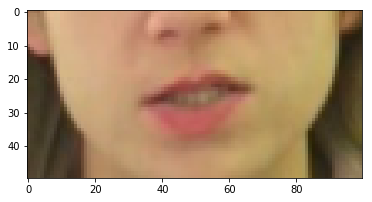

20


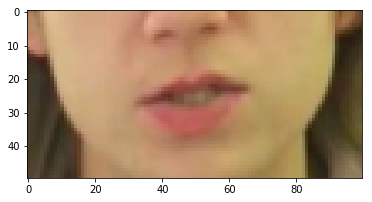

21
green


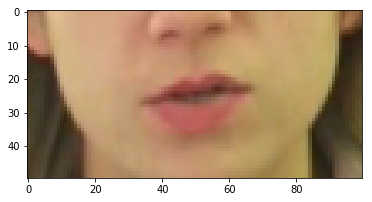

22


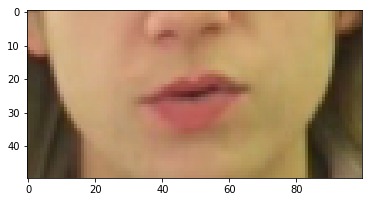

23


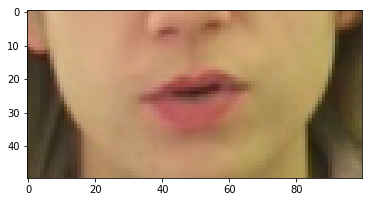

24


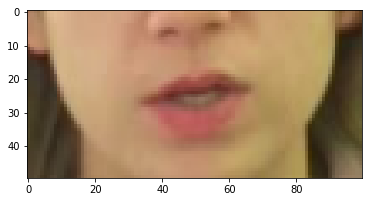

25


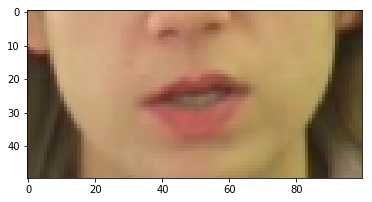

26


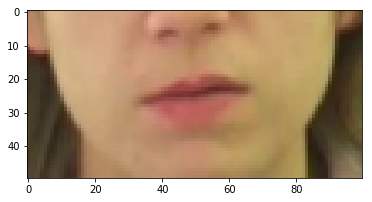

27


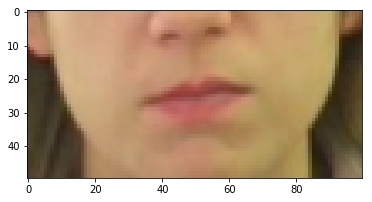

28
by


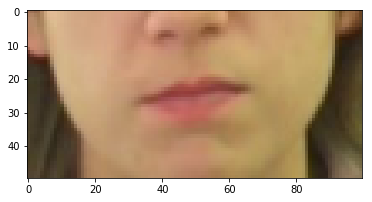

29


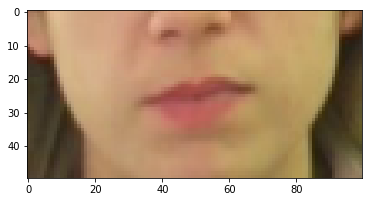

30


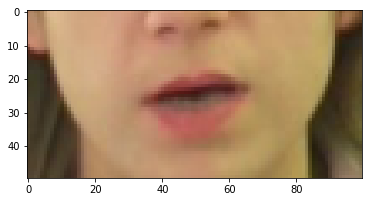

31


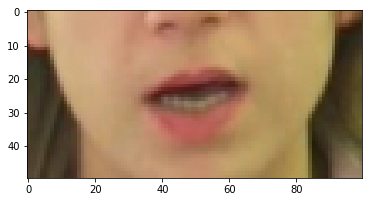

32


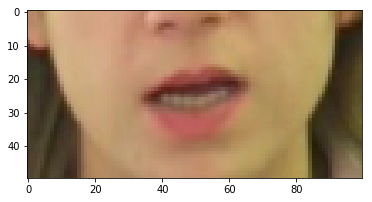

33
d


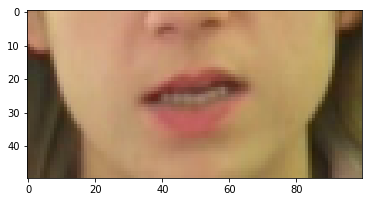

34


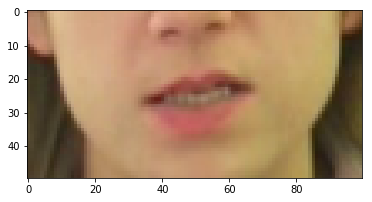

35


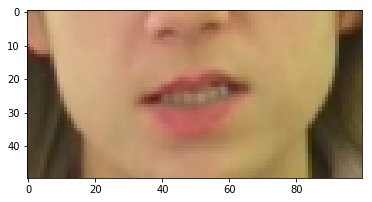

36


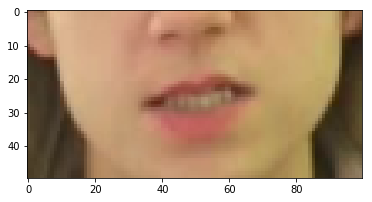

37


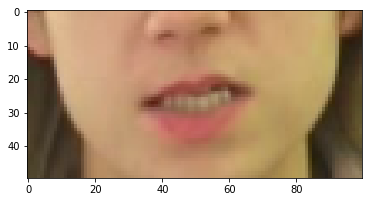

38


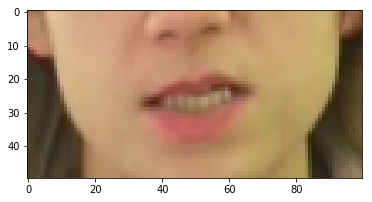

39
seven


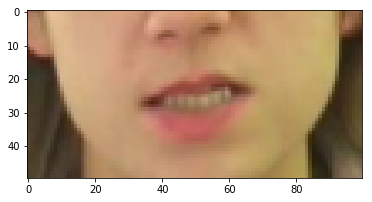

40


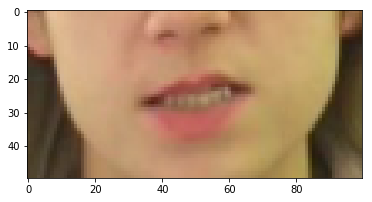

41


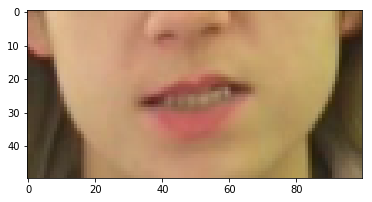

42


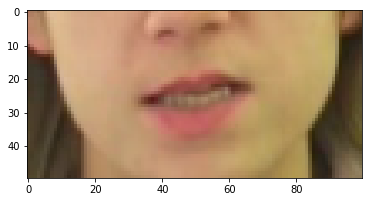

43


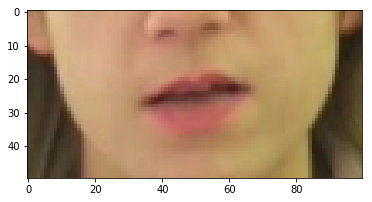

44


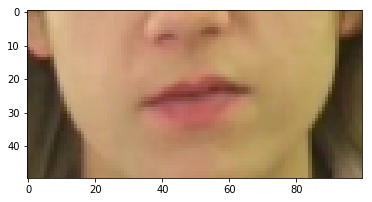

45


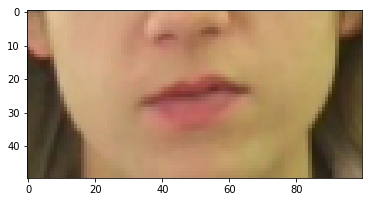

46


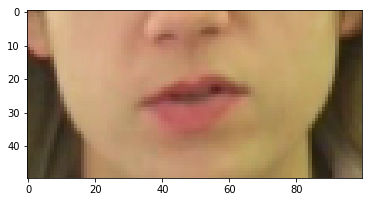

47


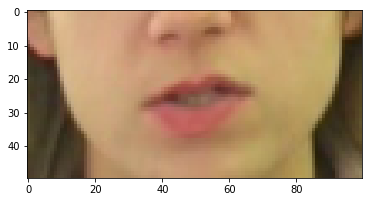

48


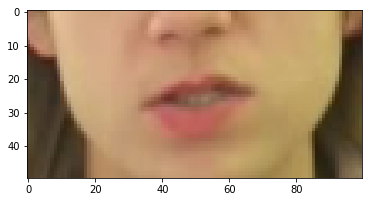

49


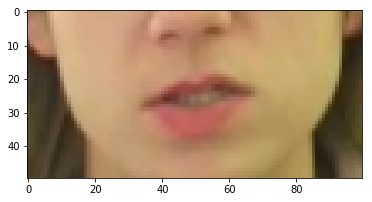

50


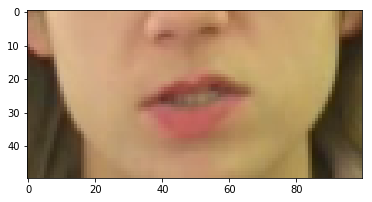

51


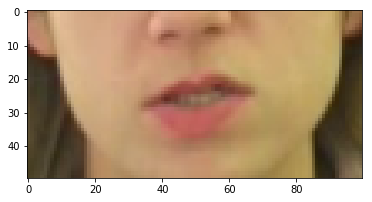

52
soon


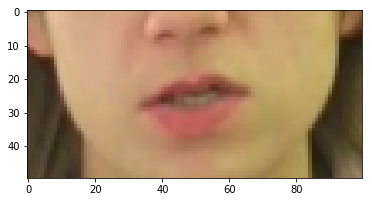

53


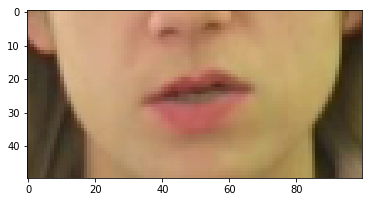

54


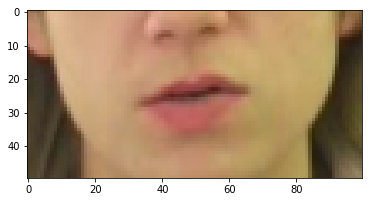

55


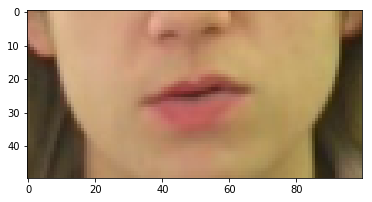

56


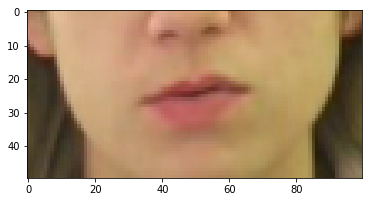

57


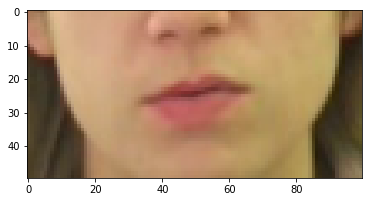

58


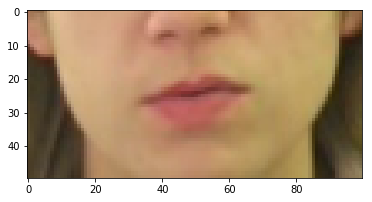

59


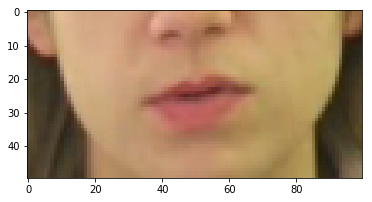

60


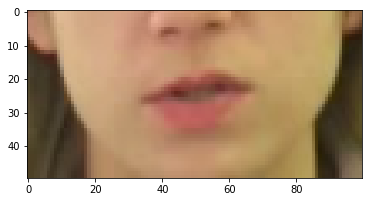

61


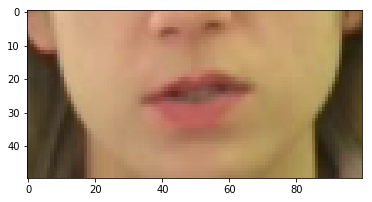

62
sil


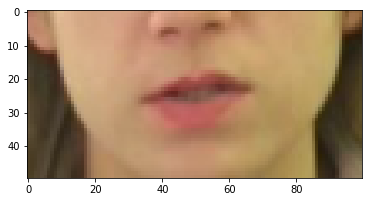

63


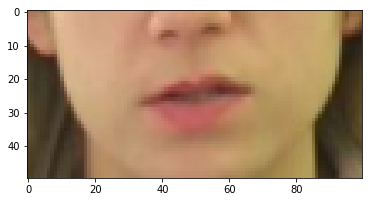

64


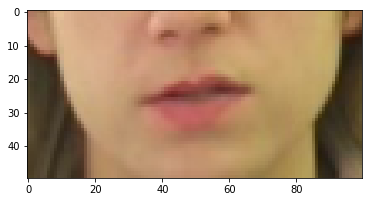

65


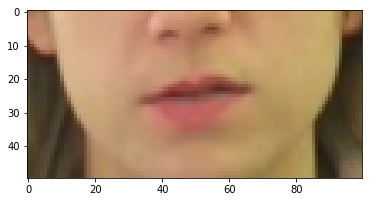

66


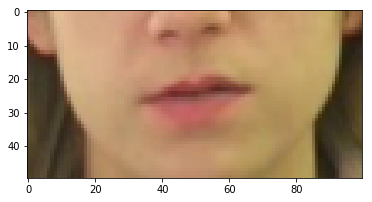

67


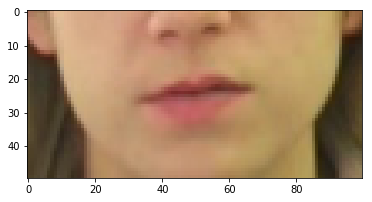

68


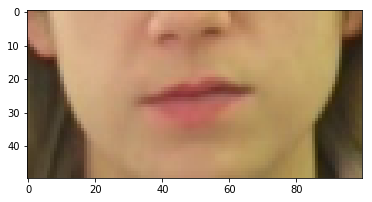

69


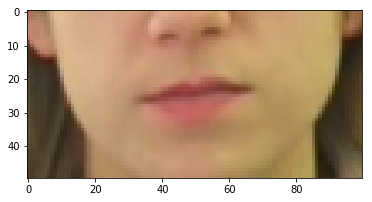

70


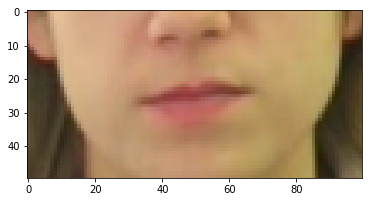

71


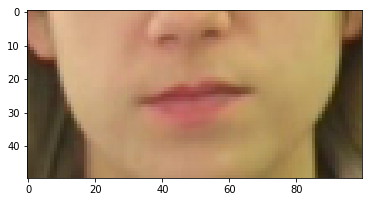

72


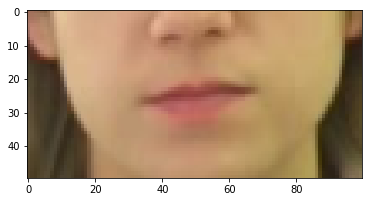

73


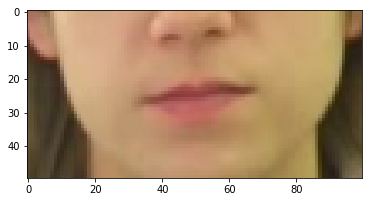

74


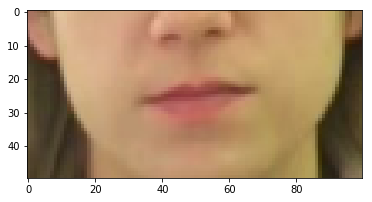

In [22]:
# show some preprocessing results
import matplotlib.pyplot as plt

for img, word in load_data(verbose=False, framebyframe=False):
    for i in range(75):
        print i
        if i == 0:
            print word[i]
        elif word[i] != word[i-1]:
            print word[i]
        plt.imshow(img[i,:,:,:])
        
        plt.show()
    break  

